In [2]:
import os
import glob
import numpy as np
import cv2
import time

from scipy import misc
from PIL import Image
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

from keras import Model
from keras.utils import to_categorical
from keras_vggface import utils
from keras_vggface.vggface import VGGFace
from keras.layers import GlobalAveragePooling2D

import nmslib

Using TensorFlow backend.


In [3]:
imgs_folder = 'M:/Mahantesh/deciphertoknow/FaceProcessing/data/preprocessed_images/'
detector = MTCNN()
model = VGGFace(model='resnet50')
def get_feature_extraction_model():
    model = VGGFace(model='vgg16', include_top=False, input_shape=image_input_shape, pooling='avg')
    output = model.get_layer('conv5_3').output
    output = GlobalAveragePooling2D()(output)
    feature_model = Model(inputs=model.input, outputs=output)
    return feature_model


image_input_shape = (224, 224, 3)

In [4]:
def extract_face(image_file, required_size=(224,224)):
    image = plt.imread(image_file)
#     start_time = time.time()
    rects = detector.detect_faces(image)
#     end_time = time.time()
#     print('Detected %d faces in %s at [%.3f] seconds' % (len(rects), image_file, (end_time - start_time)))
    if rects is None or len(rects) == 0:
        print('MTCNN did not detect face for: ' + image_file.split('\\')[-1])
        return None
    faces = []
    for rect in rects:
        x1, y1, width, height = rect['box']
        x2, y2 = x1 + width, y1 + height
    
        if y1 < 0 or y2 >= image.shape[0] or x1 < 0 or x2 >= image.shape[1]:
            print(str((x1, y1, x2, y2)) + ' is beyond image of size: ' + str(image.shape) 
                  + ' for file ' + image_file.split('\\')[-1])
            x1 = min(x1, 0)
            y1 = min(y1, 0)
            x2 = max(x2, image.shape[1])
            y2 = max(y2, image.shape[0])
            
        face = image[y1:y2, x1:x2]
        face = Image.fromarray(face)
        face = face.resize(required_size)
        face = np.asarray(face)
        faces.append(face)
    return faces

In [5]:
def get_face_embeddings(images_list):
    count = 0
    start_time = time.time()
    faces_list = []
    iter_start_time = time.time()
    for image_file in images_list:
        faces = extract_face(image_file)
        if faces is None or len(faces) <= 0:
#             print('Did not find face in image: ' + image_file.split('\\')[-1])
            continue
        faces_list.append(faces)
        count += 1
        if count % 100 == 0:
            iter_end_time = time.time()
            print('Extracted %d faces in [%.3f] seconds ' % (count, (iter_end_time - iter_start_time)))
            iter_start_time = time.time()
    end_time = time.time()
    print('Extracted faces in %d images at [%.3f] seconds' % (len(images_list), (end_time - start_time)))
    
    count = 0
    face_image_map = dict()
    all_faces = []
    for id, faces in enumerate(faces_list):
        for face in faces:
            face_image_map[count] = id
            all_faces.append(face)
            count += 1
    print('Total %d faces detected' % len(all_faces))
    start_time = time.time()
    faces = np.asarray(all_faces, 'float32')
    faces = utils.preprocess_input(faces, version=2)
    end_time = time.time()
    print('Preprocessed faces in [%.3f] seconds: ' % (end_time - start_time))
    model = get_feature_extraction_model()
    
    start_time = time.time()
    face_embeddings = model.predict(faces)
    end_time = time.time()
    print('Extracted features in [%.3f] seconds' % (end_time - start_time))
    
    return face_embeddings, face_image_map

In [82]:
images_list = glob.glob(imgs_folder + '*.jpg')
# images_list = ['M:/Mahantesh/deciphertoknow/FaceProcessing/data/processed_images\000031.jpg',
#                'M:/Mahantesh/deciphertoknow/FaceProcessing/data/processed_images\000035.jpg',
#                'M:/Mahantesh/deciphertoknow/FaceProcessing/data/processed_images\000040.jpg']
face_embedding, face_image_map = get_face_embeddings(images_list)


MTCNN did not detect face for: 000022.jpg
(185, -19, 306, 143) is beyond image of size: (512, 512, 3) for file 000041.jpg
Extracted 100 faces in [24.883] seconds 
(22, -28, 304, 354) is beyond image of size: (512, 512, 3) for file 000123.jpg
(139, -5, 397, 368) is beyond image of size: (512, 512, 3) for file 000148.jpg
MTCNN did not detect face for: 000150.jpg
(431, 196, 515, 325) is beyond image of size: (512, 512, 3) for file 000176.jpg
(73, -9, 129, 53) is beyond image of size: (512, 512, 3) for file 000199.jpg
Extracted 200 faces in [28.601] seconds 
(172, -4, 360, 264) is beyond image of size: (512, 512, 3) for file 000202.jpg
(458, 104, 513, 193) is beyond image of size: (512, 512, 3) for file 000219.jpg
(89, -28, 410, 400) is beyond image of size: (512, 512, 3) for file 000225.jpg
(270, -1, 455, 296) is beyond image of size: (512, 512, 3) for file 000241.jpg
(432, 69, 516, 205) is beyond image of size: (512, 512, 3) for file 000272.jpg
Extracted 300 faces in [27.469] seconds 
(-

In [84]:
np.asarray(face_embedding).shape

(1814, 512)

In [88]:
feature_vectors = np.array(face_embedding).astype(np.float32)
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(feature_vectors)
index.createIndex({'post': 2}, print_progress=True)

In [89]:
index.saveIndex('FaceFeatures.hnsw')

In [6]:
index = nmslib.init(method='hnsw', space='cosinesimil')
index.loadIndex('FaceFeatures.hnsw')

NameError: name 'feature_vectors' is not defined

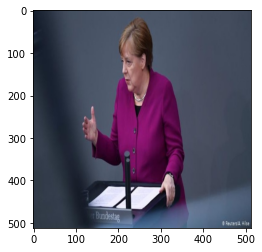

In [7]:
# plt.imshow(images_list[0])
image = 'M:/Mahantesh/deciphertoknow/FaceProcessing/data/preprocessed_images/000001.jpg'
image = plt.imread(image)
plt.imshow(image)

ids, distances = index.knnQuery(feature_vectors[1], k=100)

print(ids)
fig, axs = plt.subplots(10,10, figsize=(100,100), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i, id in enumerate(ids):
    image_file = imgs_folder + '%06d.jpg'%(face_image_map[id])
    image = plt.imread(image_file)
    axs[i].imshow(image)
    axs[i].set_title(str(face_image_map[id]) + " D:{:.3f}".format(distances[i]), fontsize=70)

[   1  114  106   22   31  101  109   96   36   20   64   57   87    5
  102   69 1561   53   24   42   75  296   61 1428    2   94    8   33
   14   78  555 1692    7  113 1198   35   91  293   13   41 1676   26
   99   52    6 1469   48   88  158   85  140   56   92   98   70   65
   17   49   25 1790  117 1465 1135 1778   12   93  176    9   18  100
 1025  116 1596 1751   45   10   51   89   54 1026   50  112   95 1301
   37  111   66   28   15  126 1709  124  303 1335   39 1057   29   21
  283  653]


NameError: name 'face_image_map' is not defined

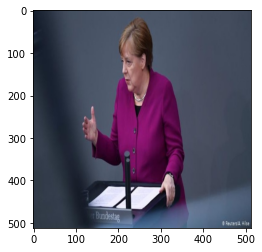

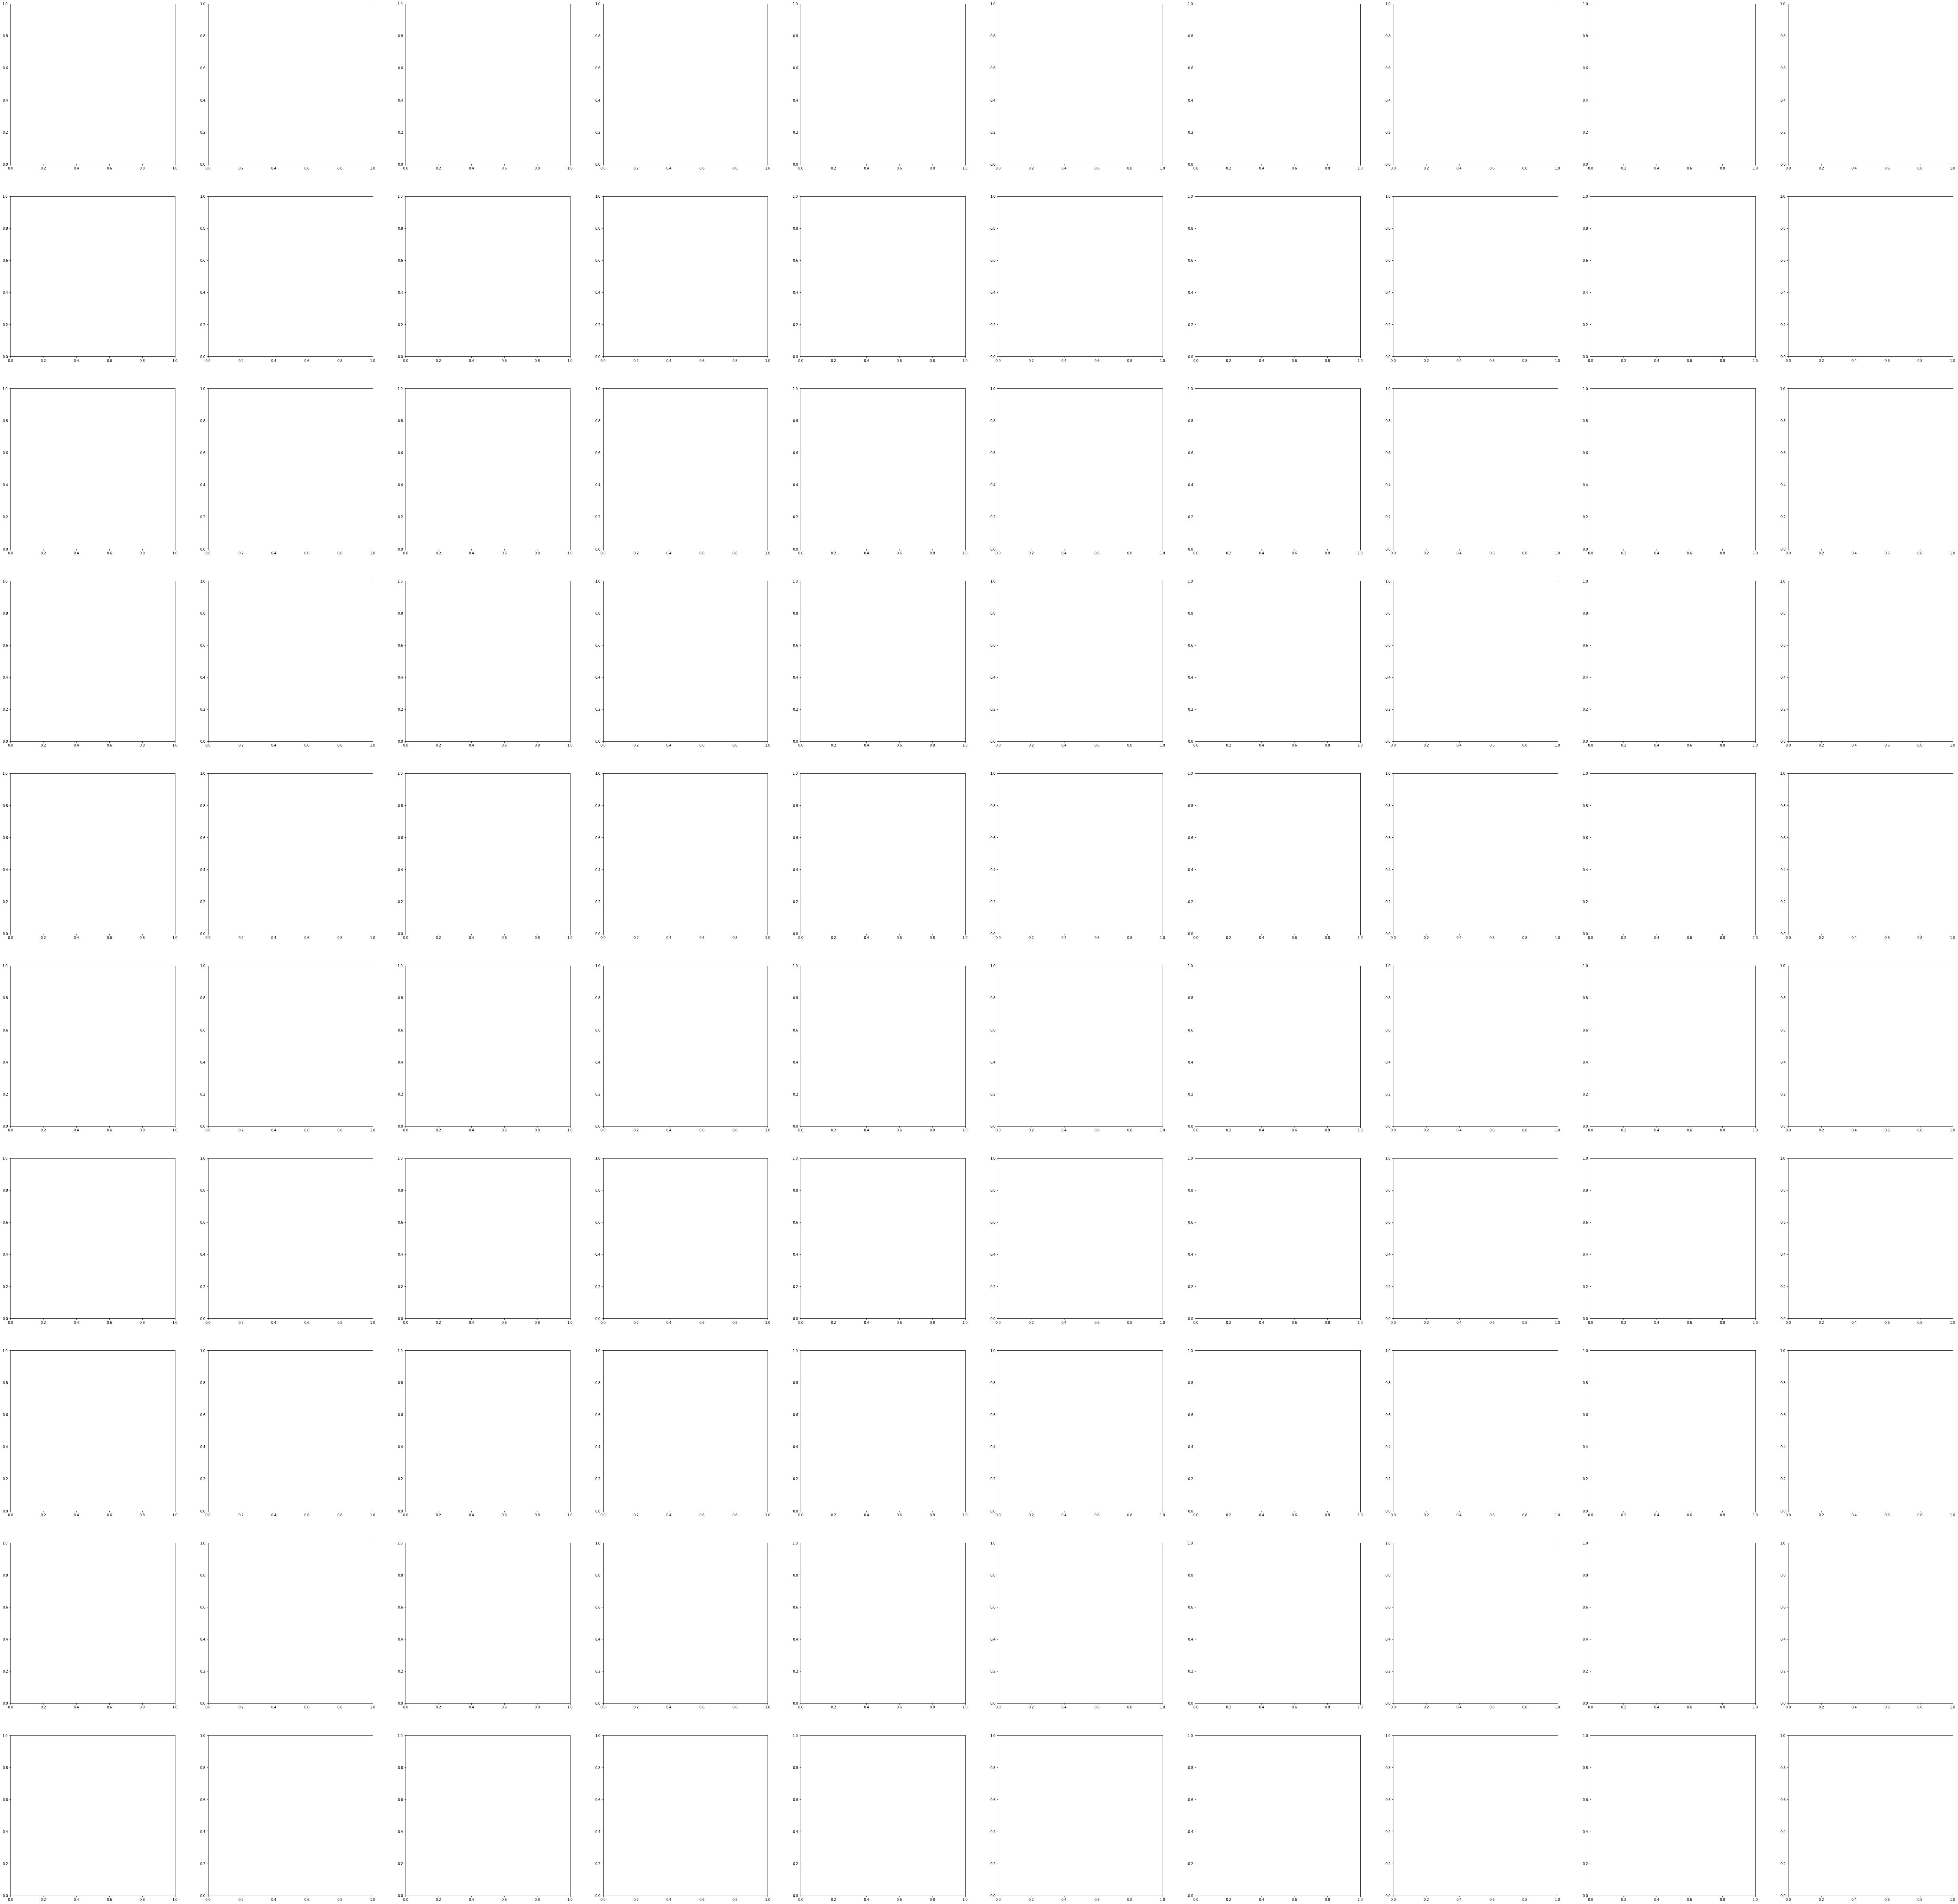

In [8]:
c = 1
image_file = 'M:/Mahantesh/deciphertoknow/FaceProcessing/data/preprocessed_images/%06d.jpg'%c

faces = extract_face(image_file)
faces = np.asarray(faces, 'float32')
faces = utils.preprocess_input(faces, version=2)
model = get_feature_extraction_model()
face_embedding = model.predict(faces)
ids, distances = index.knnQuery(face_embedding, k=100)
image = plt.imread(image_file)
plt.imshow(image)
print(ids)
fig, axs = plt.subplots(10,10, figsize=(100,100), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i, id in enumerate(ids):
    image_file = imgs_folder + '%06d.jpg'%(face_image_map[id])
    image = plt.imread(image_file)
    axs[i].imshow(image)
    axs[i].set_title(str(face_image_map[id]) + " D:{:.3f}".format(distances[i]), fontsize=70)

In [1]:
c = 768
image_file = 'M:/Mahantesh/deciphertoknow/FaceProcessing/data/preprocessed_images/%06d.jpg'%c

faces = extract_face(image_file)
faces = np.asarray(faces, 'float32')
faces = utils.preprocess_input(faces, version=2)
model = get_feature_extraction_model()
face_embedding = model.predict(faces)
ids, distances = index.knnQuery(face_embedding, k=100)
image = plt.imread(image_file)
plt.imshow(image)
print(ids)
fig, axs = plt.subplots(10,10, figsize=(100,100), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i, id in enumerate(ids):
    image_file = imgs_folder + '%06d.jpg'%(face_image_map[id])
    image = plt.imread(image_file)
    axs[i].imshow(image)
    axs[i].set_title(str(face_image_map[id]) + " D:{:.3f}".format(distances[i]), fontsize=70)

NameError: name 'extract_face' is not defined